In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import time
import random
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Subset
from torch.utils.data import random_split
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch:", torch.__version__)

PyTorch: 2.9.1+cpu


بخش 1

In [2]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()
print(model.__class__.__name__)

ResNet


In [4]:
mid_layer = model.layer3[1].conv2
final_layer = model.fc

W_mid = mid_layer.weight.detach().cpu()
W_final = final_layer.weight.detach().cpu()

print("Mid layer weight shape:", tuple(W_mid.shape))
print("Final layer weight shape:", tuple(W_final.shape))

Mid layer weight shape: (256, 256, 3, 3)
Final layer weight shape: (1000, 512)


In [5]:
def to_2d_matrix(W: torch.Tensor) -> np.ndarray:
    if W.ndim == 2:
        M = W
    elif W.ndim == 4:
        M = W.reshape(W.shape[0], -1)
    else:
        raise ValueError(f"Unsupported weight ndim={W.ndim}, shape={tuple(W.shape)}")
    return M.numpy()

M_mid = to_2d_matrix(W_mid)
M_final = to_2d_matrix(W_final)

print("Mid matrix shape for SVD:", M_mid.shape)
print("Final matrix shape for SVD:", M_final.shape)

Mid matrix shape for SVD: (256, 2304)
Final matrix shape for SVD: (1000, 512)


In [6]:
def svd_singular_values(M: np.ndarray) -> np.ndarray:
    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    return S

def cumulative_energy(S: np.ndarray) -> np.ndarray:
    S2 = S**2
    return np.cumsum(S2) / np.sum(S2)

S_mid = svd_singular_values(M_mid)
S_final = svd_singular_values(M_final)

E_mid = cumulative_energy(S_mid)
E_final = cumulative_energy(S_final)

print("Mid rank :", len(S_mid))
print("Final rank :", len(S_final))

Mid rank : 256
Final rank : 512


In [7]:
def k_for_threshold(E: np.ndarray, threshold: float = 0.95) -> int:
    return int(np.searchsorted(E, threshold) + 1)

k95_mid = k_for_threshold(E_mid, 0.95)
k95_final = k_for_threshold(E_final, 0.95)

print(f"Mid layer: k for 95% energy = {k95_mid} out of {len(S_mid)}  -> {100*k95_mid/len(S_mid):.2f}% of singular values")
print(f"Final layer: k for 95% energy = {k95_final} out of {len(S_final)} -> {100*k95_final/len(S_final):.2f}% of singular values")

Mid layer: k for 95% energy = 199 out of 256  -> 77.73% of singular values
Final layer: k for 95% energy = 291 out of 512 -> 56.84% of singular values


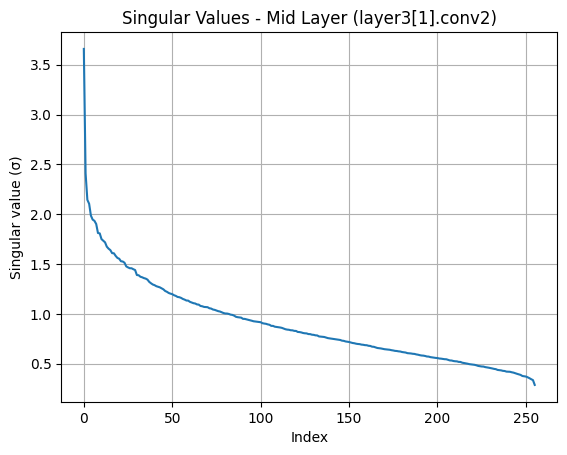

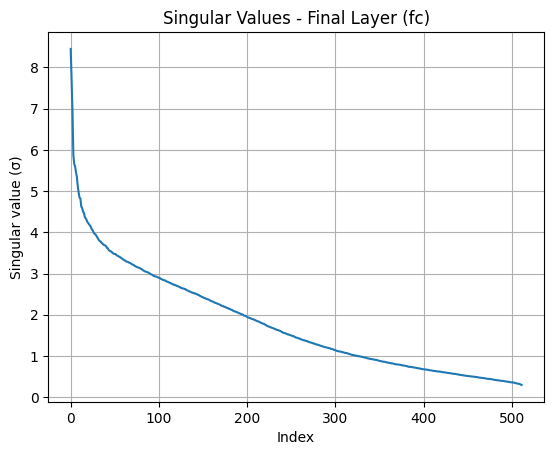

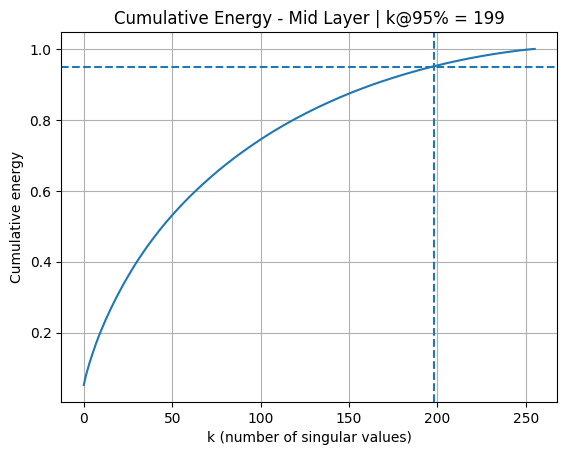

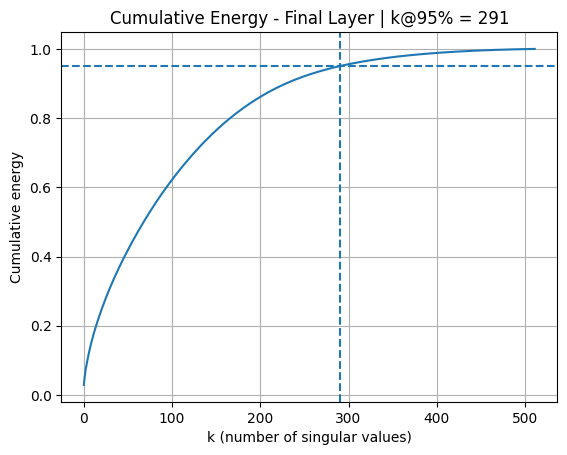

In [8]:
def plot_singular_values(S: np.ndarray, title: str):
    plt.figure()
    plt.plot(S)
    plt.xlabel("Index")
    plt.ylabel("Singular value (σ)")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_cumulative_energy(E: np.ndarray, k95: int, title: str):
    plt.figure()
    plt.plot(E)
    plt.axhline(0.95, linestyle="--")
    plt.axvline(k95-1, linestyle="--")
    plt.xlabel("k (number of singular values)")
    plt.ylabel("Cumulative energy")
    plt.title(f"{title} | k@95% = {k95}")
    plt.grid(True)
    plt.show()

plot_singular_values(S_mid, "Singular Values - Mid Layer (layer3[1].conv2)")
plot_singular_values(S_final, "Singular Values - Final Layer (fc)")

plot_cumulative_energy(E_mid, k95_mid, "Cumulative Energy - Mid Layer")
plot_cumulative_energy(E_final, k95_final, "Cumulative Energy - Final Layer")

بخش 2

In [9]:
def low_rank_factorize_linear(linear: nn.Linear, k: int) -> nn.Sequential:

    W = linear.weight.detach()
    b = linear.bias.detach() if linear.bias is not None else None
    U, S, Vh = torch.linalg.svd(W, full_matrices=False)
    U_k = U[:, :k]
    S_k = S[:k]
    Vh_k = Vh[:k, :]
    layer1 = nn.Linear(linear.in_features, k, bias=False)
    layer2 = nn.Linear(k, linear.out_features, bias=(linear.bias is not None))

    with torch.no_grad():
        layer1.weight.copy_(Vh_k)
        layer2.weight.copy_(U_k * S_k.unsqueeze(0))
        if b is not None:
            layer2.bias.copy_(b)

    return nn.Sequential(layer1, layer2)

In [10]:
def get_module_by_name(model: nn.Module, name: str):
    cur = model
    for part in name.split("."):
        cur = cur[int(part)] if part.isdigit() else getattr(cur, part)
    return cur

def set_module_by_name(model: nn.Module, name: str, new_module: nn.Module):
    parts = name.split(".")
    parent = model
    for part in parts[:-1]:
        parent = parent[int(part)] if part.isdigit() else getattr(parent, part)
    last = parts[-1]
    if last.isdigit():
        parent[int(last)] = new_module
    else:
        setattr(parent, last, new_module)

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

In [11]:
def choose_k_for_param_reduction(linear: nn.Linear, reduction: float) -> int:
    in_f, out_f = linear.in_features, linear.out_features
    old_params = out_f * in_f + (out_f if linear.bias is not None else 0)

    bias_params = out_f if linear.bias is not None else 0
    target = (1 - reduction) * old_params

    denom = in_f + out_f
    k = int(np.floor((target - bias_params) / denom))
    k = max(1, min(k, min(in_f, out_f)))
    return k

def compress_one_linear_layer(model: nn.Module, layer_name: str, reduction: float):
    m = copy.deepcopy(model)
    layer = get_module_by_name(m, layer_name)
    if not isinstance(layer, nn.Linear):
        raise TypeError(f"Layer '{layer_name}' must be nn.Linear, but got {type(layer)}")
    k = choose_k_for_param_reduction(layer, reduction=reduction)
    new_block = low_rank_factorize_linear(layer, k)
    set_module_by_name(m, layer_name, new_block)
    return m, k

In [12]:
layer_to_compress = "fc"
baseline = model
compressed_50, k50 = compress_one_linear_layer(baseline, layer_to_compress, reduction=0.50)
compressed_80, k80 = compress_one_linear_layer(baseline, layer_to_compress, reduction=0.80)
print("k50 =", k50, "| k80 =", k80)

k50 = 168 | k80 = 67


In [13]:
rows = []
for name, m, k in [
    ("No Compression", baseline, None),
    ("50% compression", compressed_50, k50),
    ("80% compression", compressed_80, k80),
]:
    rows.append({
        "Model": name,
        "k (rank)": "-" if k is None else int(k),
        "Total Params": count_params(m),
    })
df_params = pd.DataFrame(rows)
df_params

,Model,k (rank),Total Params
0,No Compression,-,11689512
1,50% compression,168,11431528
2,80% compression,67,11278816


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

IMAGENET_VAL_DIR = r"C:\Users\Ali\OneDrive\Desktop\New folder\data mining\tamrin 6\val_blurred"

tfm = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

if not os.path.isdir(IMAGENET_VAL_DIR):
    raise FileNotFoundError(f"Folder not found: {IMAGENET_VAL_DIR}")

val_ds = datasets.ImageFolder(IMAGENET_VAL_DIR, transform=tfm)
rng = np.random.RandomState(42)
eval_idx = rng.choice(len(val_ds), size=min(1000, len(val_ds)), replace=False)
val_ds_1000 = Subset(val_ds, eval_idx.tolist())
val_loader = DataLoader(val_ds_1000, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

print("Val samples (fixed random subset):", len(val_ds_1000), "| Classes:", len(val_ds.classes))

Device: cpu
Val samples (fixed random subset): 1000 | Classes: 1000


In [22]:
@torch.no_grad()
def top1_accuracy(model: nn.Module, loader: DataLoader) -> float:
    model.eval().to(device)
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

def evaluate_models():
    results = []
    for name, m in [
        ("No Compression", baseline),
        ("50% compression", compressed_50),
        ("80% compression", compressed_80),
    ]:
        t0 = time.time()
        acc = top1_accuracy(m, val_loader)
        dt = time.time() - t0
        results.append({"Model": name, "Top-1 Acc": acc, "Eval Time (s)": dt})
    return pd.DataFrame(results)

df_acc = evaluate_models()
df_acc

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,Model,Top-1 Acc,Eval Time (s)
0,No Compression,0.695,15.406138
1,50% compression,0.661,17.506426
2,80% compression,0.559,14.837461


بخش ۳

In [23]:
TRAIN_MAX = 5000

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])
train_full = datasets.ImageFolder(IMAGENET_VAL_DIR, transform=train_tfm)
N = len(train_full)
mask = np.ones(N, dtype=bool)
mask[np.array(eval_idx, dtype=int)] = False
remain_idx = np.where(mask)[0]
rng = np.random.RandomState(123)
train_idx = rng.choice(remain_idx, size=min(TRAIN_MAX, len(remain_idx)), replace=False)
train_ds = Subset(train_full, train_idx.tolist())
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
eval_loader = val_loader
print("Train samples:", len(train_ds), "| Eval samples:", len(eval_loader.dataset))

Train samples: 5000 | Eval samples: 1000


In [24]:
@torch.no_grad()
def top1_accuracy(model, loader):
    model.eval().to(device)
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

def set_trainable_fc_only(model):
    for p in model.parameters():
        p.requires_grad = False
    for p in model.fc.parameters():
        p.requires_grad = True

def fine_tune_fc_only(model, epochs=3, lr=1e-3, weight_decay=1e-4):
    set_trainable_fc_only(model)
    model.to(device)
    opt = torch.optim.Adam([p for p in model.parameters() if p.requires_grad],
                           lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            loss = criterion(model(x), y)
            loss.backward()
            opt.step()
            running += loss.item() * y.size(0)

        train_loss = running / len(train_loader.dataset)
        acc = top1_accuracy(model, eval_loader)
        print(f"Epoch {ep}/{epochs} | train_loss={train_loss:.4f} | eval_acc={acc:.4f}")

    return model

acc_base_before = top1_accuracy(baseline, eval_loader)
acc_50_before   = top1_accuracy(compressed_50, eval_loader)
acc_80_before   = top1_accuracy(compressed_80, eval_loader)

print("Before FT:", acc_base_before, acc_50_before, acc_80_before)

ft_50 = fine_tune_fc_only(compressed_50, epochs=3)
ft_80 = fine_tune_fc_only(compressed_80, epochs=3)
acc_50_after = top1_accuracy(ft_50, eval_loader)
acc_80_after = top1_accuracy(ft_80, eval_loader)

df_acc = pd.DataFrame([
    {"Model": "Baseline",       "Compression": 0.0, "Acc(before)": acc_base_before, "Acc(after)": acc_base_before},
    {"Model": "50% Compressed", "Compression": 0.5, "Acc(before)": acc_50_before,   "Acc(after)": acc_50_after},
    {"Model": "80% Compressed", "Compression": 0.8, "Acc(before)": acc_80_before,   "Acc(after)": acc_80_after},
])

df_acc

C:\Users\Ali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Before FT: 0.695 0.661 0.559
Epoch 1/3 | train_loss=2.0173 | eval_acc=0.6470
Epoch 2/3 | train_loss=1.6779 | eval_acc=0.6270
Epoch 3/3 | train_loss=1.4482 | eval_acc=0.6260
Epoch 1/3 | train_loss=2.4681 | eval_acc=0.5610
Epoch 2/3 | train_loss=2.1343 | eval_acc=0.5570
Epoch 3/3 | train_loss=1.9379 | eval_acc=0.5600


,Model,Compression,Acc(before),Acc(after)
0,Baseline,0.0,0.695,0.695
1,50% Compressed,0.5,0.661,0.626
2,80% Compressed,0.8,0.559,0.560


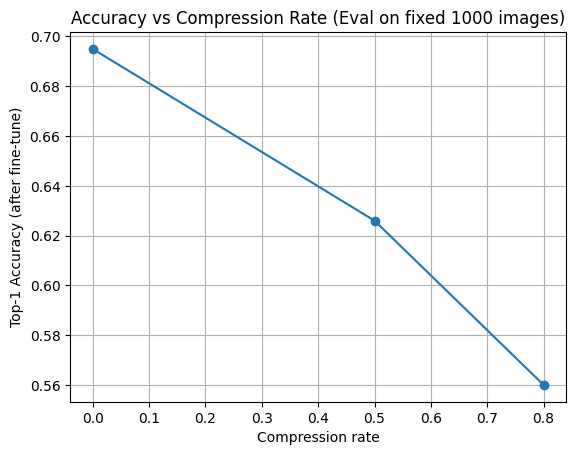

In [26]:
def cpu_speed(model, loader, warmup_batches=3, timed_batches=10):
    m = model.to("cpu").eval()
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= warmup_batches: break
            _ = m(x)
    n_images = 0
    t0 = time.perf_counter()
    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= timed_batches: break
            _ = m(x)
            n_images += x.size(0)
    t1 = time.perf_counter()
    sec = t1 - t0
    return {"img_per_sec": n_images / sec, "ms_per_img": 1000 * sec / n_images}

df_speed = pd.DataFrame([
    {"Model": "Baseline",            **cpu_speed(baseline, eval_loader)},
    {"Model": "50% Compressed (FT)", **cpu_speed(ft_50, eval_loader)},
    {"Model": "80% Compressed (FT)", **cpu_speed(ft_80, eval_loader)},
])

df_speed
x = df_acc["Compression"].values
y = df_acc["Acc(after)"].values
plt.figure()
plt.plot(x, y, marker="o")
plt.xlabel("Compression rate")
plt.ylabel("Top-1 Accuracy (after fine-tune)")
plt.title("Accuracy vs Compression Rate (Eval on fixed 1000 images)")
plt.grid(True)
plt.show()